# Определение перспективного тарифа для телеком-компании


Клиентам предлагается два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

## Задачи


Провести анализ поведения клиентов и сделать вывод - какой тариф лучше подходит для дальнейшей рекламы.

1. Подготовить данные:
    1.1. Привести данные к нужным типам;
    1.2. Найти и исправить ошибки если они есть;
    1.3. Посчитать для каждого пользователя количество сделанных звонков и израсходованных минут по месяцам, количество отправленных сообщений по месяцам, объем израсходованного трафика и помесячную выручку.
2. Проанализировать данные:
    2.1. Провести подсчет сколько минут разговора, сколько сообщений и какой объем трафика требуется пользователям каждого тарифа в месяц;
    2.2. Посчитайть среднее количество, дисперсию и стандарное отклонение;
    2.3. Построить гистограммы.
3. Проверьте гипотезы.

## Данные и общая информация


In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
from scipy import stats

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col = 0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

На первом этапе имеем 5 разных датасетов. У всех, кроме tariffs, есть общий столбец id и user_id .

## Подготовка данных


### Звонки


In [2]:
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Датасет имеет 4 столбца: id, call_date, duration, user_id.
call_date перевоим к нужому датафрейму. 
duration округляем в болльшую сторону и меняем тип данных на int. 
Добавляем новый столбец с месяцем. 
Группируем данные о количестве звонков и сумме минут по user_id и месяцам.
Пропусков нет.

In [3]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls['duration'] = np.ceil(calls['duration']).astype('int')
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

data_calls = calls.groupby(['user_id', 'month']).agg({'duration': ['count', 'sum']})
data_calls = data_calls.rename(columns = {'duration' : 'call_count',})


data_calls.info()
data_calls.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   (call_count, count)  3174 non-null   int64
 1   (call_count, sum)    3174 non-null   int64
dtypes: int64(2)
memory usage: 62.9 KB


call_count     
                   count  sum
user_id month                
1000    5             22  159
        6             43  172
        7             47  340
        8             52  408
        9             58  466

### Интернет

In [4]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Датасет имеет 5 столбцов: id, mb_used, session_date, user_id.
session_date перевоим к нужому датафрейму. Добавляем новый столбец с месяцем. 
Группируем данные о использованных Мб по user_id и месяцам. Преобразовываем из в Гб и округляем в большую сторону.
Пропусков нет.

In [5]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
internet['month'] = pd.DatetimeIndex(internet['session_date']).month


data_internet = np.ceil(internet.groupby(['user_id', 'month']).agg({'mb_used' : ['sum']})/1024).astype('int')
data_internet.head()

mb_used
                  sum
user_id month        
1000    5           3
        6          23
        7          14
        8          14
        9          15

### Сообщения

In [6]:
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Датасет имеет 3 столбца: id, message_date, user_id.
message_date перевоим к нужому датафрейму. Добавляем новый столбец с месяцем.
Группируем данные о количестве сообщений по user_id и месяцам.
Пропусков нет.

In [7]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

data_messages = messages.groupby(['user_id', 'month']).agg({'id' : ['count']})


data_messages.head()

id
              count
user_id month      
1000    5        22
        6        60
        7        75
        8        81
        9        57

### Тариф

In [8]:
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Датасет имеет 8 столбцjd: messages_included, mb_per_month_included, minutes_included, rub_monthly_fee, rub_per_gb, rub_per_message, rub_per_minute, tariff_name. Мб переведены в Гб. Столбик tariff_name переименован в tariff для слияния с data.
Все числовые значения имеют тип данных int.
Пропусков нет.
С информацией ознакомилась, к ней вернусь позже.

In [9]:
tariffs['mb_per_month_included'] = (tariffs['mb_per_month_included']/1024).astype('int')

tariffs = tariffs.rename(columns = {'tariff_name' : 'tariff'})

tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


### Пользователи

In [10]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Датасет имеет 8 столбцов: user_id, age, churn_date, city, first_name, last_name, reg_date, tariff.
Есть пропуски churn_date, как указано в ТЗ это обозначает, что поключение к тарифу актуально на момент выгрузки данных. 
Создаем новый датасет с необходимыми нам данными по пользователям.

In [11]:
data_users = users.loc[:, ['user_id', 'city', 'tariff']]

data_users.head()

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


### Объединение датасетов

In [12]:
data = data_calls.merge(data_internet, on = ['user_id', 'month'], how = 'outer')
data = data.merge(data_messages, on = ['user_id', 'month'], how = 'outer')
data = data.rename(
    columns = {
        'mb_used' : 'web_traffic',
        'id' : 'message',
    }
)

data['web_traffic'] = data['web_traffic'].fillna(0)
data['web_traffic'] = data['web_traffic'].astype('int')
data['message'] = data['message'].fillna(0)
data['message'] = data['message'].astype('int')

data = data.reset_index()
display(data.head(2))

data = data.merge(data_users, on = 'user_id', how = 'outer')
data = data.merge(tariffs, on = 'tariff', how = 'outer')

data['call_count', 'count'] = data['call_count', 'count'].fillna(0).astype('int')
data['call_count', 'sum'] = data['call_count', 'sum'].fillna(0).astype('int')
data['web_traffic', 'sum'] = data['web_traffic', 'sum'].fillna(0).astype('int')
data['message', 'count'] = data['message', 'count'].fillna(0).astype('int')


data.info()
data.head()

user_id month call_count        web_traffic message
                     count    sum         sum   count
0    1000     5       22.0  159.0           3      22
1    1000     6       43.0  172.0          23      60

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   (user_id, )            3214 non-null   float64
 2   (month, )              3214 non-null   float64
 3   (call_count, count)    3216 non-null   int64  
 4   (call_count, sum)      3216 non-null   int64  
 5   (web_traffic, sum)     3216 non-null   int64  
 6   (message, count)       3216 non-null   int64  
 7   city                   3216 non-null   object 
 8   tariff                 3216 non-null   object 
 9   messages_included      3216 non-null   int64  
 10  mb_per_month_included  3216 non-null   int64  
 11  minutes_included       3216 non-null   int64  
 12  rub_monthly_fee        3216 non-null   int64  
 13  rub_per_gb             3216 non-null   int64  
 14  rub_per_message        3216 non-null   int64  
 15  rub_

,user_id,"(user_id, )","(month, )","(call_count, count)","(call_count, sum)","(web_traffic, sum)","(message, count)",city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,1000.0,5.0,22,159,3,22,Краснодар,ultra,1000,30,3000,1950,150,1,1
1,1000,1000.0,6.0,43,172,23,60,Краснодар,ultra,1000,30,3000,1950,150,1,1
2,1000,1000.0,7.0,47,340,14,75,Краснодар,ultra,1000,30,3000,1950,150,1,1
3,1000,1000.0,8.0,52,408,14,81,Краснодар,ultra,1000,30,3000,1950,150,1,1
4,1000,1000.0,9.0,58,466,15,57,Краснодар,ultra,1000,30,3000,1950,150,1,1


Объединили 5 датасетов: телефонные звонки, интернет трафик, сообщения, данные по пользователям тарифы. Датасет сгрупирован по user_id и сведен по месяцам.
Для удобства переменованы столбцы. Пропуски заполнены. Тип приведен к целым числам.

### Подсчет помесячной выручки

In [13]:
def revenue_call(row):
    overspending_minutes = row['call_count', 'sum'] - row['minutes_included']
    if overspending_minutes >= 0:
        return overspending_minutes * row['rub_per_minute']
    return 0
data['additional_calls'] = data.apply(revenue_call, axis = 1)


def revenue_internet(row):
    overspending_internet = row['web_traffic', 'sum'] - row['mb_per_month_included']
    if overspending_internet >= 0:
        return overspending_internet * row['rub_per_gb']
    return 0
data['additional_internet'] = data.apply(revenue_internet, axis = 1)


def revenue_message(row):
    overspending_message = row['message', 'count'] - row['messages_included']
    if overspending_message >= 0:
        return overspending_message * row['rub_per_message']
    return 0
data['additional_message'] = data.apply(revenue_message, axis = 1)


data['total_revenue'] = data['additional_calls'] + data['additional_internet'] + data['additional_message'] + data['rub_monthly_fee']

data.info()
data.head(10)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   (user_id, )            3214 non-null   float64
 2   (month, )              3214 non-null   float64
 3   (call_count, count)    3216 non-null   int64  
 4   (call_count, sum)      3216 non-null   int64  
 5   (web_traffic, sum)     3216 non-null   int64  
 6   (message, count)       3216 non-null   int64  
 7   city                   3216 non-null   object 
 8   tariff                 3216 non-null   object 
 9   messages_included      3216 non-null   int64  
 10  mb_per_month_included  3216 non-null   int64  
 11  minutes_included       3216 non-null   int64  
 12  rub_monthly_fee        3216 non-null   int64  
 13  rub_per_gb             3216 non-null   int64  
 14  rub_per_message        3216 non-null   int64  
 15  rub_

,user_id,"(user_id, )","(month, )","(call_count, count)","(call_count, sum)","(web_traffic, sum)","(message, count)",city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,additional_calls,additional_internet,additional_message,total_revenue
0,1000,1000.0,5.0,22,159,3,22,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
1,1000,1000.0,6.0,43,172,23,60,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
2,1000,1000.0,7.0,47,340,14,75,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
3,1000,1000.0,8.0,52,408,14,81,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
4,1000,1000.0,9.0,58,466,15,57,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
5,1000,1000.0,10.0,57,350,15,73,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
6,1000,1000.0,11.0,43,338,15,58,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
7,1000,1000.0,12.0,46,333,10,70,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
8,1003,1003.0,8.0,55,380,9,37,Москва,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
9,1003,1003.0,9.0,134,961,13,91,Москва,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950


Для подсчета было создано 3 функции: для звонков(additional_calls), интернета(additional_internet) и сообщений(additional_message). После все эти данные совместно с тарифом ссумировались и получили полную сумму за каждый месяц (total_revenue).

In [14]:
# check
data['total_revenue'].sum()

4916951

In [15]:
# check
data[['user_id', ('call_count', 'sum'),  ('web_traffic', 'sum'),
          ('message', 'count'), 'tariff',  'additional_calls',   'additional_internet', 'additional_message',
      'total_revenue']].tail(4)

,user_id,"(call_count, sum)","(web_traffic, sum)","(message, count)",tariff,additional_calls,additional_internet,additional_message,total_revenue
3212,1489,0,20,21,smart,0,1000,0,1550
3213,1489,0,18,20,smart,0,600,0,1150
3214,1489,0,17,35,smart,0,400,0,950
3215,1371,0,0,0,smart,0,0,0,550


## Анализ данных


### Количество минут

#### Среднее, дисперсия и гистограмма

In [16]:
data_smart = data.loc[data.loc[:, 'tariff'] == 'smart']
data_ultra = data.loc[data.loc[:, 'tariff'] == 'ultra']

data_smart['call_count_sum_smart'] = data_smart['call_count', 'sum']
data_ultra['call_count_sum_ultra'] = data_ultra['call_count', 'sum']

data_smart['web_trafic_smart'] = data_smart['web_traffic', 'sum']
data_ultra['web_trafic_ultra'] = data_ultra['web_traffic', 'sum']

data_smart['message_smart'] = data_smart['message', 'count']
data_ultra['message_ultra'] = data_ultra['message', 'count']

In [17]:
# check 
data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 0 to 985
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                986 non-null    int64  
 1   (user_id, )            985 non-null    float64
 2   (month, )              985 non-null    float64
 3   (call_count, count)    986 non-null    int64  
 4   (call_count, sum)      986 non-null    int64  
 5   (web_traffic, sum)     986 non-null    int64  
 6   (message, count)       986 non-null    int64  
 7   city                   986 non-null    object 
 8   tariff                 986 non-null    object 
 9   messages_included      986 non-null    int64  
 10  mb_per_month_included  986 non-null    int64  
 11  minutes_included       986 non-null    int64  
 12  rub_monthly_fee        986 non-null    int64  
 13  rub_per_gb             986 non-null    int64  
 14  rub_per_message        986 non-null    int64  
 15  rub_pe

In [18]:
# check 
data_smart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2230 entries, 986 to 3215
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2230 non-null   int64  
 1   (user_id, )            2229 non-null   float64
 2   (month, )              2229 non-null   float64
 3   (call_count, count)    2230 non-null   int64  
 4   (call_count, sum)      2230 non-null   int64  
 5   (web_traffic, sum)     2230 non-null   int64  
 6   (message, count)       2230 non-null   int64  
 7   city                   2230 non-null   object 
 8   tariff                 2230 non-null   object 
 9   messages_included      2230 non-null   int64  
 10  mb_per_month_included  2230 non-null   int64  
 11  minutes_included       2230 non-null   int64  
 12  rub_monthly_fee        2230 non-null   int64  
 13  rub_per_gb             2230 non-null   int64  
 14  rub_per_message        2230 non-null   int64  
 15  ru

Подготавливаем данные

Среднее количество минут Smart 417.747533632287
Среднее количество минут Ultra 526.0892494929006

Дисперсия Smart 36281.39383644458
Дисперсия Ultra 101052.49354928387

Гистограмма минут


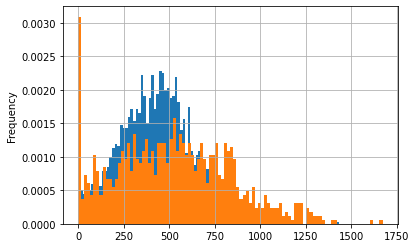

In [19]:
data_smart['call_count_sum_smart'].plot(kind = 'hist', bins = 100, grid = True, density = True)
data_ultra['call_count_sum_ultra'].plot(kind = 'hist', bins = 100, grid = True, density = True)

call_smart_var = np.var(data_smart['call_count_sum_smart'], ddof=1)
call_ultra_var = np.var(data_ultra['call_count_sum_ultra'], ddof=1)

print('Среднее количество минут Smart', data_smart['call_count_sum_smart'].mean())
print('Среднее количество минут Ultra', data_ultra['call_count_sum_ultra'].mean())
print('')
print('Дисперсия Smart', call_smart_var)
print('Дисперсия Ultra', call_ultra_var)
print('')
print('Гистограмма минут')

#### Редкие и выбивающиеся значения

##### Звонки Smart

count    2230
mean      418
std       190
min         0
25%       282
50%       422
75%       545
max      1435
Name: call_count_sum_smart, dtype: int64

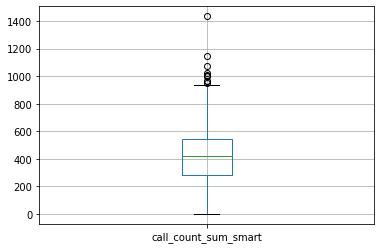

0.9959641255605381

count     2214
unique     351
top       1113
freq        12
Name: call_count_sum_smart, dtype: int64

In [20]:
display(data_smart['call_count_sum_smart'].describe().round(0).astype(int))
data_smart.boxplot('call_count_sum_smart')
plt.show()
display(len(data_smart.query('call_count_sum_smart > 0'))/len(data_smart))
data_smart['call_count_sum_smart'] = data_smart.query('call_count_sum_smart <= 900')
display(data_smart['call_count_sum_smart'].describe().round(0).astype(int))

##### Звонки Ultra

count     986
mean      526
std       318
min         0
25%       282
50%       518
75%       752
max      1673
Name: call_count_sum_ultra, dtype: int64

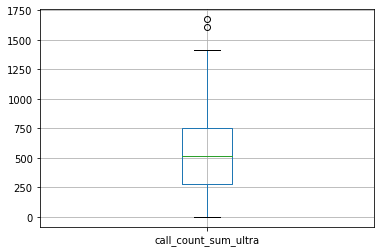

0.960446247464503

count      982
unique     149
top       1385
freq        12
Name: call_count_sum_ultra, dtype: int64

In [21]:
display(data_ultra['call_count_sum_ultra'].describe().round(0).astype(int))
data_ultra.boxplot('call_count_sum_ultra')
plt.show()
display(len(data_ultra.query('call_count_sum_ultra > 0'))/len(data_ultra))
data_ultra['call_count_sum_ultra'] = data_ultra.query('call_count_sum_ultra <= 1350')
display(data_ultra['call_count_sum_ultra'].describe().round(0).astype(int))

### Количество трафика Гб

#### Среднее, дисперсия и гистограмма

Среднее количество трафика Smart 16.32152466367713
Среднее количество трафика Ultra 19.474645030425965

Дисперсия Smart 33.133453035506285
Дисперсия Ultra 97.37854429011234

Гистограмма Гб


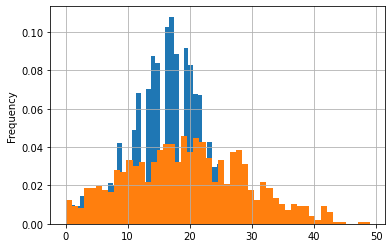

In [22]:
data_smart['web_trafic_smart'].plot(kind = 'hist', bins = 50, grid = True, density = True)
data_ultra['web_trafic_ultra'].plot(kind = 'hist', bins = 50, grid = True, density = True)

trafic_smart_var = np.var(data_smart['web_trafic_smart'], ddof=1)
trafic_ultra_var = np.var(data_ultra['web_trafic_ultra'], ddof=1)

print('Среднее количество трафика Smart', data_smart['web_trafic_smart'].mean())
print('Среднее количество трафика Ultra', data_ultra['web_trafic_ultra'].mean())
print('')
print('Дисперсия Smart', trafic_smart_var)
print('Дисперсия Ultra', trafic_ultra_var)
print('')
print('Гистограмма Гб')

#### Редкие и выбивающиеся значения

##### Интернет Smart

count    2230
mean       16
std         6
min         0
25%        13
50%        17
75%        20
max        38
Name: web_trafic_smart, dtype: int64

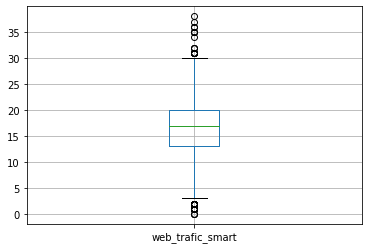

0.9726457399103139

count     2212
unique     351
top       1496
freq        12
Name: web_trafic_smart, dtype: int64

In [23]:
display(data_smart['web_trafic_smart'].describe().round(0).astype(int))
data_smart.boxplot('web_trafic_smart')
plt.show()
display(len(data_smart.query('web_trafic_smart > 3'))/len(data_smart))
data_smart['web_trafic_smart'] = data_smart.query('web_trafic_smart <= 30')
display(data_smart['web_trafic_smart'].describe().round(0).astype(int))

##### Интернет Ultra

count    986
mean      19
std       10
min        0
25%       12
50%       19
75%       27
max       49
Name: web_trafic_ultra, dtype: int64

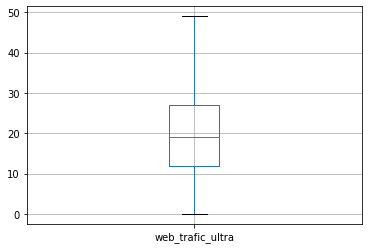

0.9878296146044625

count      986
unique     149
top       1126
freq        12
Name: web_trafic_ultra, dtype: int64

In [24]:
display(data_ultra['web_trafic_ultra'].describe().round(0).astype(int))
data_ultra.boxplot('web_trafic_ultra')
plt.show()
display(len(data_ultra.query('web_trafic_ultra > 0'))/len(data_ultra))
data_ultra['web_trafic_ultra'] = data_ultra.query('web_trafic_ultra <= 49')
display(data_ultra['web_trafic_ultra'].describe().round(0).astype(int))

### Количество сообщений

#### Среднее, дисперсия и гистограмма

Среднее количество сообщений Smart 33.36905829596412
Среднее количество сообщений Ultra 49.31338742393509

Дисперсия Smart 796.9552557301129
Дисперсия Ultra 2285.4174246558414

Гистограмма сообщений


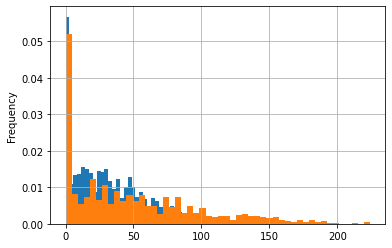

In [25]:
data_smart['message_smart'].plot(kind = 'hist', bins = 50, grid = True, density = True)
data_ultra['message_ultra'].plot(kind = 'hist', bins = 50, grid = True, density = True)

message_smart_var = np.var(data_smart['message_smart'], ddof=1)
message_ultra_var = np.var(data_ultra['message_ultra'], ddof=1)

print('Среднее количество сообщений Smart', data_smart['message_smart'].mean())
print('Среднее количество сообщений Ultra', data_ultra['message_ultra'].mean())
print('')
print('Дисперсия Smart', message_smart_var)
print('Дисперсия Ultra', message_ultra_var)
print('')
print('Гистограмма сообщений')

#### Редкие и выбивающиеся значения

##### Сообщения Smart

count    2230
mean       33
std        28
min         0
25%        10
50%        28
75%        51
max       143
Name: message_smart, dtype: int64

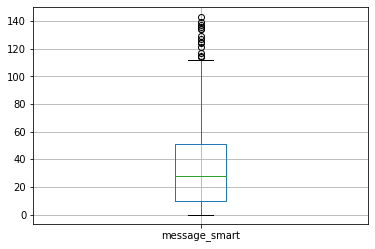

0.8618834080717489

count     2212
unique     351
top       1394
freq        12
Name: message_smart, dtype: int64

In [26]:
display(data_smart['message_smart'].describe().round(0).astype(int))
data_smart.boxplot('message_smart')
plt.show()
display(len(data_smart.query('message_smart > 0'))/len(data_smart))
data_smart['message_smart'] = data_smart.query('message_smart <= 110')
display(data_smart['message_smart'].describe().round(0).astype(int))

##### Сообщения Ultra

count    986
mean      49
std       48
min        0
25%        6
50%       38
75%       79
max      224
Name: message_ultra, dtype: int64

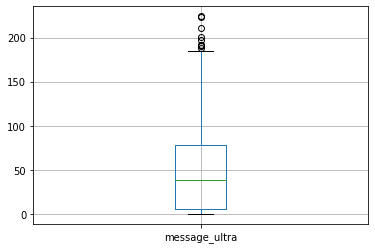

0.8062880324543611

count      973
unique     149
top       1396
freq        12
Name: message_ultra, dtype: int64

In [27]:
display(data_ultra['message_ultra'].describe().round(0).astype(int))
data_ultra.boxplot('message_ultra')
plt.show()
display(len(data_ultra.query('message_ultra > 0'))/len(data_ultra))
data_ultra['message_ultra'] = data_ultra.query('message_ultra <= 180')
display(data_ultra['message_ultra'].describe().round(0).astype(int))

### Общая выручка тарифов

In [28]:
print('Общая выручка за 2018 год Smart:', data_smart['total_revenue'].sum())
print('Общая выручка за 2018 год Ultra:', data_ultra['total_revenue'].sum())


Общая выручка за 2018 год Smart: 2875901
Общая выручка за 2018 год Ultra: 2041050


### Сравнение тарифов

In [34]:
data = data.rename(columns={('month', ''):'month'})

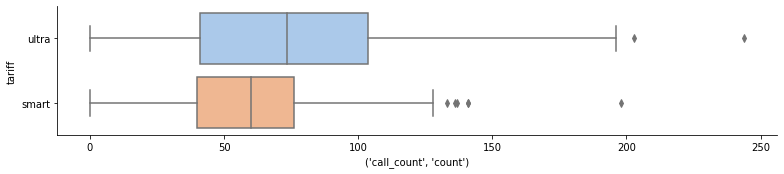

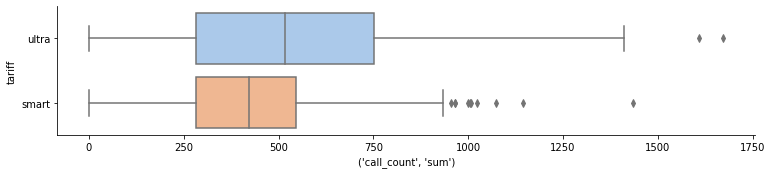

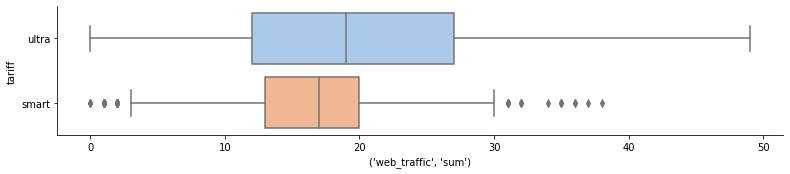

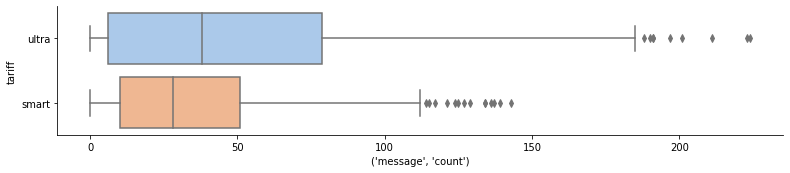

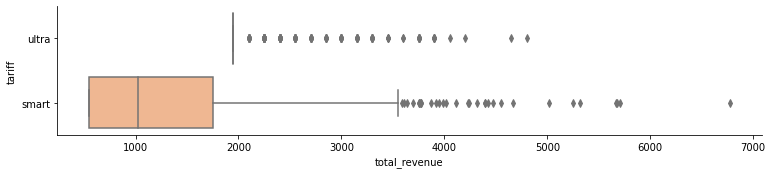

In [36]:
for column in [('call_count', 'count'),
         ('call_count', 'sum'),  ('web_traffic', 'sum'),
          ('message', 'count'), 'total_revenue']:    
    g = sns.catplot(y='tariff', x=column, kind="box", data=data, orient='h', palette = 'pastel')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)

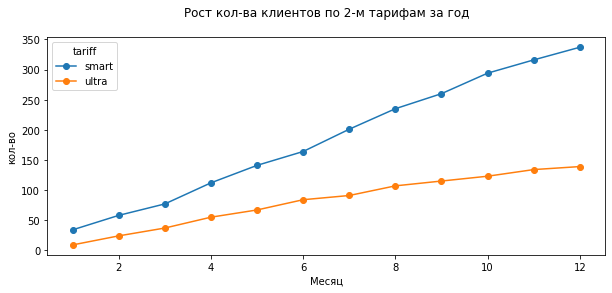

In [37]:
(data
 .pivot_table(index='tariff', columns='month', values='user_id', aggfunc='count')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Рост кол-ва клиентов по 2-м тарифам за год'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Кол-во');

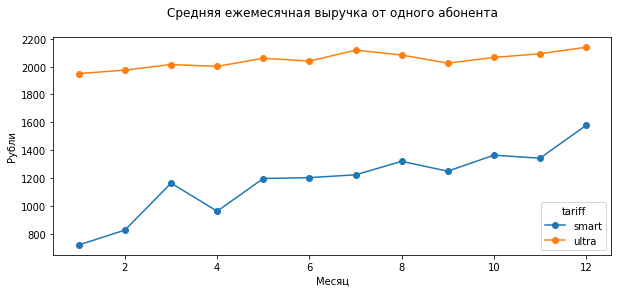

In [38]:
(data
 .pivot_table(index='tariff', columns='month', values='total_revenue', aggfunc='mean')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Средняя ежемесячная выручка от одного абонента'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли');

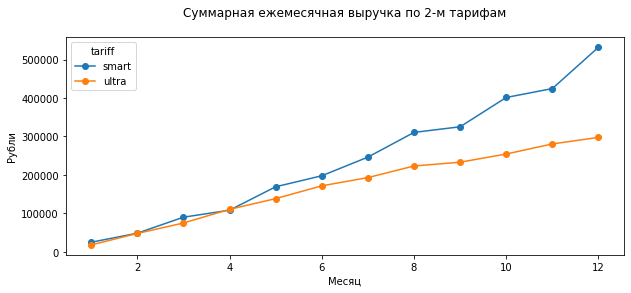

In [39]:
(data
 .pivot_table(index='tariff', columns='month', values='total_revenue', aggfunc='sum')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Суммарная ежемесячная выручка по 2-м тарифам'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли');

### Отток клиентов

In [40]:
df_users = pd.read_csv('/datasets/users.csv')

print ('Кол-во клентов покинувших компанию за год', df_users.churn_date.notna().sum())

print ('Кол-во клентов покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах',
       df_users.query('churn_date > "2018-09-25"').churn_date.notna().sum()
      )
print ('%  от общего кол-ва всех клиентов, покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах',
    (df_users.query('churn_date > "2018-09-25"').churn_date.notna().sum()/df_users.churn_date.notna().sum()*100).round(1)
)

print ('Распределение оттока клиентов на тарифах за посл. 4 мес. 2018 г.')
df_users.query('churn_date > "2018-09-25"').groupby('tariff')['churn_date'].count().to_frame()

Кол-во клентов покинувших компанию за год 38
Кол-во клентов покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах 35
%  от общего кол-ва всех клиентов, покинувших компанию за посл. 4 мес. 2018 г. на двух тарифах 92.1
Распределение оттока клиентов на тарифах за посл. 4 мес. 2018 г.


,churn_date
tariff,
smart,22
ultra,13


### Вывод


Количество звонков, трафика и сообщений на тарифе Ультра расходуется больше чем на тарифе Смарт, но количество пользователей на тарифе Смарт превышает тариф Ультра и соответственно выручка больше, в основном из-за перерасхода трафика или звонков сверх тарифа, что создает риск потери клиентов, т.к. мы видим, что отток усилиается. Необходим пересмотр тарифной политики.

## Проверка гипотезы


### Гипотеза 1: Средняя выручка пользователей тарифов "Смарт" и "Ультра" различаются


Выборки независимые.
Нулевая гипотеза-средная выручка между тарифами неразличаются.
Альтернативная гипотеза-средняя выручка тарифов различаются.

In [29]:
alpha = .05
results = stats.ttest_ind(data_smart['total_revenue'], data_ultra['total_revenue'], equal_var = False)
print('р-значение =', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение = 1.927011394420941e-250
Отвергаем нулевую гипотезу


### Гипотеза 1: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Выборки независимые.
Нулевая гипотеза-средняя выручка между пользователями Москвы и регионов неразличаются.
Альтернативная гипотеза-средняя выручка между пользователями Москвы и регионов различаются.

In [30]:
moscow = data.loc[data.loc[:, 'city'] == 'Москва']
region = data.loc[data.loc[:, 'city'] != 'Москва']

alpha = .05
results = stats.ttest_ind(moscow['total_revenue'], region['total_revenue'], equal_var = False)
print('р-значение =', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение = 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value 0.5216952110000278 говорит о том, что хотя средний чек Москвы и регионов разный, с вероятностью в 52% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними чеками.

## Вывод


1. Абонентская плата тарифа Smart 550 руб., что почти в 3.5 раза меньше чем абонентская плата тарифа Ultra 1950 руб. 
   
   Соответсвенно число пользователей тарифа Smart выше почти в 3.5 раза. Из выборки в 500 абонентов число пользоватей Smart - 351. Число пользователей Ultra - 149.



2. Тариф Ultra приобретают в основном клиенты с большим расходом минут разговора и трафика. 

   Средний расход Ultra: минуты - 526, трафик - 19.
   Средний расход Smart: минуты - 417, трафик - 16. 
   
   Но часто у клиентов тарифа Smart происходит перерасход одной из услуг(минуты или трафик), т.е. пользователи пользуются услугами сверх тарифного плана, что способствует увеличению выручки и оттоку клиентов одновременно.




3. Из-за большего количества пользователей, а так же перерасхода трафика и минут общая выручка Smart превышает выручку Ultra почти на 40%:

   Smart - 2 875 901.00 руб.
   Ultra - 2 041 050.00 руб.



4. Тариф Smart рекомендуется для дальнейшей рекламы. Так же необходимо расширить тарифную линейку для клиентов, чей расход превышает лимит Smart, но не дотягивает до Ultra, иначе есть риск усиления оттока клиентов.